## A tutorial on [Information Maximizing Visual Question Generation](https://arxiv.org/pdf/1903.11207.pdf)
Written by [Nihir](mailto:nv419@ic.ac.uk)

Resources used:
- https://www.borealisai.com/en/blog/tutorial-5-variational-auto-encoders/
- https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
- https://anotherdatum.com/vae.html
- **https://www.youtube.com/watch?v=nug3rz-4Lkg** (Highly recommended)
- https://deisenroth.cc/teaching/2018-19/probabilistic-inference/
- https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vae-variational-autoencoder
- https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/#chen2016variational
- https://arxiv.org/abs/1906.02691
- https://www.cs.cmu.edu/~epxing/Class/10708-17/notes-17/10708-scribe-lecture8.pdf

In this tutorial, I attempt to decompose and provide intuition behind the methodology of the titled paper. My background, in general, is not maths based, and my deep learning knowledge coming into this paper did not include variational inference. Because of this, despite being able to follow their code, I was stumped trying to understand the logic of their formulations. Here, I will take us on a journey of reimplementation, starting from the assumption that you have no knowledge about probabilistic modelling, and finishing with an understanding of how, and why:
1. Variational Inference works
2. Incorporating Mutual Information can enhance the ELBO objective
3. The Information Maximising VQG paper works

The tutorial will therefore be structured as follows:
- Introduction: The case for Bayesian modelling
 - Definitions
- Variational Inference
 - Deriving ELBO
- Incorporating Mutual Information to overcome ELBO shortcomings
- Information Maximising Visual Question Generation
 - Code!


## Introduction: The case for Bayesian modelling

In many ML tasks, we want to probabilistically model certain events happening, or probabilistically generate certain data types (e.g. images). Neural networks are tools used in order to compute the representations of the data that we'll use in these models.

In the Bayesian modelling framework, we want to learn a probability distribution $P(\mathbf{x})$ over a multi-dimensional input variable $\mathbf{x}$. Doing this enables us to generate realistic-looking $x$ samples from the distribution. For example, in the case of images:

<img src="images/vae_mnist.png" style="width: 800px" />

Other differing algorithms which allow us to do generation exist. GANs are probably the most well known of these. One advantage of probabilstic Bayesian modelling is that we are able to compute uncertainity of our model predictions. A hypothetical stock trading model might output a prediction to "Buy", but if it is only 10% sure, this probably isn't a decision I want to take action on:

<img src="images/uncertainty.png" style="width: 800px" />

### Definitions

- **Expectation** $\mathbb{E}$ of a variable is a probability weighted average
 - $\mathbb{E}[X] = \sum_i x_i p(x_i)$ if $X$ is discrete.
 - $\mathbb{E}[X] = \int_i x_i p(x_i) dx$ if $X$ is continuous.
- **Kullback-Leibler divergence** is a non-negative quantity which measures the divergence in two probability distributions
 - $\mathcal{D}_{KL}(P || Q) = \int p(x) \frac{p(x)}{q(x)} dx$ when $P$ and $Q$ are distributions of a continuous RV 
- The **product rule** of probability states that a joint probability can be expressed in terms of likelihoods and priors:
 - $p(A,B) = p(A | B)p(B)$
- **Bayes rule** is a way of describes the probability of an event, based on prior knowledge of conditions that might be related to the event:
 - $p(A | B) = \frac{p(B|A)p(A)}{p(B)}$
- **Mutual information** between two variables tells us how indicative one variable is of another
 - $I(X, Y) = I(X) + I(Y) - I(XY) /geq 0 $
 - $I(X, Y) = \mathcal{D}_{KL}(P{(X,Y)} || P(x) P(y)) = \mathbb{E}_{P_{(X,Y)}} [\log \frac{P(X,Y)}{P(x)P(y)}]$
 - $I(X, Y) = \mathbb{H}(Y) - \mathbb{H}(Y|X)$
   - $\mathbb{H}(Y|X) = \int_{x, y} p(x, y) \log \frac{p(x,y)}{p(x)} dxdy$

## Variational Inference

Firstly, let's move away from how we currently think about ML problems - that is fitting inputs $\mathbf{x}$ to a prediction $\hat{y}$, and optimizing this versus a ground truth $y$: $\mathcal{L}(\hat{y}, y)$.

We instead want to find a _latent_ variable, $\mathbf{z} \in \mathbb{R}^m$. Each vector in $z$ contains $m$ elements of information that encodes hidden information not directly observable from the training data. If we're generating  MNIST digits for example, abstracting speaking, the first dimension might encode a number representing a digit, the second stroke intensity, the third angle, and so forth.

We represent our model using something known as a directed graphical model. This model simply indicate what nodes are reliant on other nodes. For our set up, the graphical model is as follows:

<img src="images/graph_model.png" style="width: 600px" />

This model tells us that the distribution of $\mathbf{x}$ is conditioned on $\mathbf{z}$. Given an image $x$, we want to find at least one latent vector which can "describe" this image.

Specifically, **we want to calculate the posterior** - we want to infer good values of the latent variable given the observed data. Using Bayes rule, this is given as: $$p(\mathbf{z | x}) \triangleq \frac{p(\mathbf{x, z})}{p(\mathbf{x})} \\ 
= \frac{p(\mathbf{x}|\mathbf{z})p(\mathbf{z})}{p(\mathbf{x})}$$

- $p(\mathbf{z|x}$ is the posterior
- $p(\mathbf{x|z})$ is the likelihood
- $p(\mathbf{z})$ is the prior
- $p(\mathbf{x})$ is the evidence

As the prior is an assumption we make, and the likelihood is modelled by a multivariate Guassian (we'll talk about this later), we **need to find a way to evaluate $p(\mathbf{x})$**: $$p(\mathbf{x}) \triangleq \int p(\mathbf{x, z}) d\mathbf{z} \triangleq \int p(\mathbf{x|z})p(\mathbf{z}) d\mathbf{z}$$ 

**Where does this come from?**
1. The first assignment, $p(\mathbf{x}) \triangleq \int p(\mathbf{x, z}) d\mathbf{z}$, is a process known as *marginalisation*.
 - Marginalisation of a variable, in this case $\mathbf{x}$, is defined as the probability distribution of $\mathbf{x}$ when the values of other variable, $\mathbf{z}$, are not considered.
 - In the continuous case, this is **calculated by integrating the joint probability distribution** with respect to the other variable: $\int p(\mathbf{x, z}) d\mathbf{z}$
2. The second assignment, $\int p(\mathbf{x, z}) d\mathbf{z} \triangleq \int p(\mathbf{x|z})p(\mathbf{z}) d\mathbf{z}$ simply comes from Bayes rule: $$p(\mathbf{x, z}) \triangleq p(\mathbf{x}|\mathbf{z})p(\mathbf{z})$$

**What does it mean?**

The integral means that, over the latent space, 
- for every candidate $z \in \mathbf{z}$, what is the likelihood that $x$ was generated from $z$?
 - For example, if the $z$ encodes information about the digit 7, then a model could be almost as likely to generate an image of a 1 instead of a 7 - because they look similar to each other. It would be highly unlikely for it to produce a 6.
- Did we find a good candidate ($z$)? Great! But what's the probability of this $z$ existing?
 - For example, let's say we were given a image showing an upside down 7. A latent vector, $z$, describing a similar looking 7 with the 'angle dimenson' set to $180^{\circ}$ would be the ideal $z$ to use to generate a sample. But how likely is this $z$? It isn't likely since digits are not typically drawn upside down.

<br>
<br>

Ok. So we want to optimize to find ${\max p(x)}$. Let's use $\log$ probabilities and see what we're working with: $$\max \log p(\mathbf{x}) = \max \log \int p(\mathbf{x|z})p(\mathbf{z}) d\mathbf{z}$$

It turns out that this integral is intractable to compute. Relatively simple expressions for $p(\mathbf{x|z})$ and $p(\mathbf{z})$ can describe complex distributions for $p(\mathbf{x})$. Let's look at an example.


### The intractable integral


![image.png](images/intractible_example.png)

What we want to do is infer nature's process on the creation of these clusters. What processes would nature have to go through create this data in this way?

Perhaps nature has access to $K$ clusters, and it picks one of these clusters, $k_i$. Subsequently, it picks from $k_i$'s distribution and returns us a datapoint. By doing this $N$ times, we assume we'll have something similar to the datapoints we've observed.

Note that this is just an assumption that we're making about how nature generated these points. The real process could be very different and more complicated, but the aim is that we want to get as close to the real process as possible under these assumptions.

**Bayesian mixture of Gaussians**

Let's assume that nature samples a cluster $k_i$ from some categorical distribution over $K$, and a point from a Guassian with 0 mean and variance $\sigma^2$

![](images/nature_sampling_process.png)

- $\mu_k \sim \mathcal{N}(0, \sigma^2). k = 1, ..., K$
 - Cluster centers are sampled from the Gaussian distribution with 0 mean and \sigma^2 variance.
 - There are K cluster centers (i.e. one for each cluster)
- $\mathbf{c_i} \sim \text{Cat}(K) \quad \text{for} \: i = 1, ..., N$
 - Each datapoint is part of a distinct cluster
 - The cluster for this datapoint, $\mathbf{c_i}$, is a one hot vector
 - We can initially assume our categorical distribution is uniform

What the above conveys is our prior beliefs about something. We can use the cluster center alongside its respective cluster to generate a datapoint: $$\mathbf{x_i|(c_i, \mu)} \sim \mathcal{N}(\mathbf{c_i^T\mu},\sigma_2^2) \quad i = 1, ..., N$$

Let's break this down a bit...
- Each $\mathbf{c_i^T} \in \mathbb{R}^K$ is simply a one hot (row) vector. For example, $[0, 1, ... 0]$
- $\mathbf{\mu} \in \mathbb{R}^K$ is a (column) vector of the cluster centers. For example, $\mathbf{\mu} = [\mu_1, \mu_2, ..., \mu_K]^T$
- The inner product of one hot vector with another vector essentially returns the value in the second vector at the index where there is a 1 in the one hot vector:
 - $\mathbf{c_i^T}\mu = [0, 1, ..., 0][\mu_1, \mu_2, ..., \mu_K]^T = \mu_2$

This $\mu_k$ is used as the mean when generating a sample $\mathbf{x_i}$. We fit the variance $\sigma_2^2$ during training. If we are able to find the best distribution that the means and variances are sampled from, then we have a good solution to this clustering problem.

Here, we'll link this back to our max marginal:
$$\max \log p(\mathbf{x}) = \max \log \int p(\mathbf{x, z}) d\mathbf{z} = \max \log \int p(\mathbf{x|z})p(\mathbf{z}) d\mathbf{z}$$

Our $\mathbf{z}$ now consists of two vectors, $\mathbf{\mu}$ and $\mathbf{c}$: $$\mathbf{z} = \{\mathbf{\mu}, \mathbf{c}\}$$.

Our goal is to maximise $p(\mathbf{x})$. Forumated by marginalising with the aforementioned $\mathbf{z}$, we obtain:
$$\log p(\mathbf{x}) = \log \int_\mu \sum_c p(\mathbf{x, c, \mu}) d\mathbf{\mu}$$

(We have an integral for $\mu$ because it is continuous, and a summation for $\mathbf{c}$ because it is discrete.)

We see that our **marginalisation process has as many aggregations (i.e. integrals or summations) as latent dimensions**. This integral has no closed-form solution and thus becomes intractable to solve when we want to be more expressive with our latent variable (i.e. increase the number of dimensions)

### Variational Inference and ELBO

Variational Inference (VI) helps us deal with this kind of problem. **VI transforms computing integerals into an optimization problem**. These problems can then be solved by more familiar optimization techniques (e.g. SGD). We start by introducing a new distribution $q(\mathbf{z})$. $$\log \int p(\mathbf{x, z}) d\mathbf{z} = \log \int \frac{q(\mathbf{z})}{q(\mathbf{z})}p(\mathbf{x,z})  d\mathbf{z} = \log \mathbb{E}_{z \sim q(z)}\left[\frac{p(\mathbf{x, z})}{q(\mathbf{z})}\right]$$

The first assignment is legal as $\frac{q(\mathbf{z})}{q(\mathbf{z})} = 1$. These $\mathbf{z}$'s still "go away" due to the marginalisation process. The second assignment re-writes this form using the definition of an expectation. Note that we are calculating the expectation w.r.t. $q(\mathbf{z})$

Recall Jensen's inequality for a concave function: $f(\mathbb{E}[X]) \geq \mathbb{E}[f(x)]$.
- The LHS computes $f(x)$ over the average of some datapoints, say $x$ and $y$.
- The RHS computes $f(x)$ for the datapoints $x$ and $y$, and then averages the result of each $f(x)$
 
<img src="images/jensen_eq.png" style="width: 500px;"/>

Since logarithms are concave functions...
$$ \log \mathbb{E}_{z \sim q(z)}\left[\frac{p(\mathbf{x, z})}{q(\mathbf{z})}\right] \geq \mathbb{E}_{z \sim q(z)} \left[\log \left[\frac{p(\mathbf{x, y})}{q(\mathbf{z})} \right] \right] \\
= \mathbb{E}_{q(\mathbf{z})} \left[ \log \left[ \frac{p(\mathbf{x|z})p(\mathbf{z})}{q(\mathbf{z})} \right] \right] \\
= \mathbb{E}_{q(\mathbf{z})} \left[ \log p(\mathbf{x|z}) + \log \frac{p(\mathbf{z})}{q(\mathbf{z})} \right] \\
= \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{x|z})] + \mathbb{E}_{q(\mathbf{z})} \left[ \frac{p(\mathbf{z})}{q(\mathbf{z})} \right] \\
= \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{x|z})] - \mathbb{E}_{q(\mathbf{z})} \left[ \frac{q(\mathbf{z})}{p(\mathbf{z})} \right]
$$

Notice that $\mathbb{E}_{q(\mathbf{z})} \left[ \frac{q(\mathbf{z})}{p(\mathbf{z})} \right]$ is the definition of the KL divergence between $q(\mathbf{z})$ and $p(\mathbf{z})$. Thus, $$ \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{x|z})] - \mathbb{E}_{q(\mathbf{z})} \left[ \frac{q(\mathbf{z})}{p(\mathbf{z})} \right] = \\ \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{x|z})] - \mathcal{D}_{KL}\left(q(\mathbf{z}) || p(\mathbf{z})\right) $$.

Because $\log p(\mathbf{x}) = \log \int p(\mathbf{x, z}) d\mathbf{z}$... $$ \log p(\mathbf{x}) \geq \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{x|z})] - \mathcal{D}_{KL}\left(q(\mathbf{z}) || p(\mathbf{z})\right)$$

This is known as the Evidence Lower-Bound, aka the ***ELBO***. Since $\mathcal{D}_{KL}(\cdot||\cdot)$ is always non-negative, we arrive at the lower bound.

## Variational AutoEncoder

The Variational AutoEncoder (VAE) uses the ELBO to solve an auto-encoding task.

<img src="images/vae.png" style="width: 500px" />

We build an encoder, parameterised by $\phi$, which approximates the posterior of the true data: $q_{\phi}(\mathbf{z|x}) \approx p_{\theta}(\mathbf{z|x})$. $p_{\theta}$ is a decoder model, parameterized by $\theta$, which we want to optimize to match the true data distribution. That is, $p_{\theta^*} = p$.

We use a neural network to parameterise both $\phi$ and $\theta$: $$(\mathbf{\mu}, \log \mathbf{\sigma}) = \text{EncoderNeuralNetwork}_{\phi}(\mathbf{x}) \\
q_{\phi}(\mathbf{z|x}) = \mathcal{N}\left(\mathbf{z}; \mathbf{\mu}, \text{diag}(\mathbf{\sigma})\right) \\
p_{\theta}(\mathbf{x}|\mathbf{z}) = \text{DecoderNeuralNetwork}_{\theta}(\mathbf{z})
$$

### Reparameterization trick
Recall our objective: $$ \mathcal{L}_{\theta, \phi}(\mathbf{x}) = \mathbb{E}_{q_{\phi}(\mathbf{z})}[\log p_{\theta}(\mathbf{x|z})] - \mathcal{D}_{KL}\left(q_{\phi}(\mathbf{z}) || p(\mathbf{z})\right) \leq  \log p_{\theta}(\mathbf{x})$$

The expectation in the first term means we'll need to sample $z \sim q_{\phi}(\mathbf{z} | \mathbf{x})$. Since sampling is a stochastic process, we cannot backprop the gradient. The make this trainable, [Kingma and Welling](https://arxiv.org/abs/1312.6114) introduced the *reparameterization trick*. This trick enables $\mathbf{z}$ to be determinsitic by using an auxiliary independent random variable: $$\mathbf{z} = \mathbf{\mu} + (\mathbf{\sigma} \odot \mathbf{\epsilon})$$

where $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$

<img src="images/reparameterization_trick.png" style="width: 500px" />

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

0it [00:00, ?it/s]

9920512it [00:03, 2947257.25it/s]                                                                                      


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 110989.40it/s]                                                                                         
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


1654784it [00:00, 1770758.59it/s]                                                                                      
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


8192it [00:00, 40865.09it/s]                                                                                           


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [4]:
BATCH_SIZE = 64     # number of data points in each batch
N_EPOCHS = 10       # times to run the model on complete data
INPUT_DIM = 28 * 28 # size of each input
HIDDEN_DIM = 256    # hidden dimension
LATENT_DIM = 20     # latent vector dimension
lr = 1e-3           # learning rate

In [5]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

In [7]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]

        return predicted


In [8]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var


In [9]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [11]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss


In [15]:
best_test_loss = float('inf')

for e in tqdm(range(N_EPOCHS)):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

 10%|████████▎                                                                          | 1/10 [00:40<06:06, 40.76s/it]

Epoch 0, Train Loss: 122.94, Test Loss: 116.46


 20%|████████████████▌                                                                  | 2/10 [01:26<05:38, 42.36s/it]

Epoch 1, Train Loss: 115.10, Test Loss: 112.89


 30%|████████████████████████▉                                                          | 3/10 [02:15<05:08, 44.12s/it]

Epoch 2, Train Loss: 112.16, Test Loss: 110.73


 40%|█████████████████████████████████▏                                                 | 4/10 [03:05<04:36, 46.10s/it]

Epoch 3, Train Loss: 110.48, Test Loss: 108.95


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:49<03:47, 45.40s/it]

Epoch 4, Train Loss: 109.31, Test Loss: 108.28


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:30<02:56, 44.08s/it]

Epoch 5, Train Loss: 108.50, Test Loss: 107.73


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:09<02:07, 42.57s/it]

Epoch 6, Train Loss: 107.90, Test Loss: 107.47


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:48<01:22, 41.31s/it]

Epoch 7, Train Loss: 107.46, Test Loss: 107.11


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:26<00:40, 40.59s/it]

Epoch 8, Train Loss: 107.06, Test Loss: 106.55


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:08<00:00, 42.86s/it]

Epoch 9, Train Loss: 106.74, Test Loss: 106.00


torch.Size([1, 20])
torch.Size([28, 28])


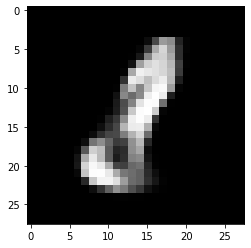

In [16]:
# sample and generate a image
z = torch.randn(1, LATENT_DIM).to(device)

# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)

plt.imshow(img, cmap='gray')

(Credit to https://graviraja.github.io/vanillavae/; https://github.com/graviraja/pytorch-sample-codes/ for the code)

## Incorporating Mutual Information to overcome ELBO shortcomings
[Zhao et al.](https://arxiv.org/pdf/1706.02262.pdf) identify that with  finite model capacity, the two goals of our objective, maximising the expected likelihood, $\mathbb{E}_{q_{\phi}(\mathbf{z})}[\log p_{\theta}(\mathbf{x|z})]$, and minimizing the KL divergence, $\mathcal{D}_{KL}\left(q_{\phi}(\mathbf{z}) || p_{\theta}(\mathbf{z})\right)$, can be conflicting. They show some subtle tradeoffs and **failure modes can emerge from optimizing the ELBO objective**.

Within the context of this tutorial, they call the following problem the *information preference* problem. Using complicated decoding distribution, $p_{\theta}(\mathbf{x} | \mathbf{z})$, has been shown to improve sample quality on complex image datasets.

However, they show that this approach usually neglects $\mathbf{z}$ altogether. That is, the mutual information between $\mathbf{z}$ and $\mathbf{x}$ becomes vanishingly small. To see the proof, please refer to the paper.

To remedy this problem, the authors do two things to our ELBO objective:
1. Add a scaling parameter $\lambda$ to the divergence between $q_{\phi}(\mathbf{z})$ and $p(\mathbf{z})$
2. Add a scaled *mutual information maximization* term that **prefers high mutual information between $\mathbf{x}$ and $\mathbf{z}$**. This encourages the model emphasise latent code and avoids the information preference problem.

Our objective is thus: $$\mathcal{L}_{\theta, \phi}(\mathbf{x}) = \mathbb{E}_{q_{\phi}(\mathbf{z})}[\log p_{\theta}(\mathbf{x|z})] - \mathcal{D}_{KL}\left(q_{\phi}(\mathbf{z}) || p(\mathbf{z})\right) + \alpha I_q(\mathbf{x}, \mathbf{z})$$

where $I_q(\mathbf{x},\mathbf{z})$ is the mutual information between $x$ and $z$ under the distribution $q_{\phi}(\mathbf{x},\mathbf{z})$.

## Information Maximising Visual Question Generation

Ok! The above gives us the background knowledge needed to understand this paper. Let's introduce what this paper does. Based on an answer category, the algorithm can generate questions which maximise the likelihood of receiving an expected answer:

<img src="images/imvqg_example.png" style="width: 800px" />

A key point is that the authors want to move away from generic generation - whether this be the generation of questions with uninformative answers (e.g. "yes"), or generic questions (e.g. "what is this person doing?"). They present an algorithm which asks questions conditioned on answer categories. This is a deviation from current variational based QG approaches as these models do not guarantee that the question will result in a specific type of answer.

They remedy this problem by encoding a desired answer with the image before generating the question (latent space). Obviously there's an issue here - the main purpose of asking questions is to attain an answer; in a real world setting, we don't have access to an answer and therefore don't have anything to encode the image with. Thus, it wouldn't be possible to generate questions without an answer.

To enable this question generation, they propose creating a second latent space that is learned from the image and the answer category instead of the answer. At test/inference time, we sample from this second latent space instead of the first. This is feasible because they minimize the KL-divergencebetween the two latent space during training. Not only does this allow us to generate visual questions that maximize mutual information with the expected answer, it also acts as a regularizer into the original latent space. It prevents the learned latent spaces from overfitting to specific answers in the training set and forces them to generalize to categories of questions

<br>
<br>

<img src="images/imvqg_approach.png" style="width: 800px" />

<br>
<br>

They annotate VQA with 15 categories (e.g. objects, attributes, colors, materials, time, etc.) for the top 500 answers.

<br>
<br>

<img src="images/imvqg_architecture.png" style="width: 800px" />

<br>
<br>

Let $q$ denote the question we want to generate for an image $i$. This  question  should  result  in  the  an  answer a of category $c$. For example, the question "What is the person in  red  doing  with  the  ball?"   should  result  in  the  answer "kicking", which belong to category "activity". Our final goal is to define a model $p(q|i,c)$. But first, let’s attempt to define a simpler model $p(q|i,a)$ that **maximizes the mutual information between the image and the question $I(i, q)$ and between the expected answer and the question $I(a, q)$**. An objective is thus formulated: $$\max I(i,q) + \lambda I(a,q)$$

where $q \sim p(q|i, a)$. $\lambda$ is a hyperparameter that adjusts for their relative importance during optimization.

A latent space, $z$, is introduced, and a mapping between the image and expected answer, $p_{\theta}(z|i, a)$, is learned. With this $z$ space, our objective is: $$ \max_{\theta}I(q, z | a, i) + \lambda_1 I(a, z) + \lambda_2 I(i, z) $$ where $z \sim p_{\theta}(z|i, a)$ and $q \sim p_{\theta}(q|z)$. Again, the $\lambda$'s weight the respective information terms.

Optimizing the mutual information maximisation is intractable because we need knowledge of the posteriors $p(z|i)$ and $p(z|a)$. As a workaround, we can optimize ELBO. Recall that $I(X, Y) = \mathbb{H}(Y) - \mathbb{H}(Y|X)$ where $\mathbb{H}(Y|X) = \int_{x, y} p(x, y) \log \frac{p(x,y)}{p(x)} dxdy$.

$$ I(z, i) = \mathbb{H}(i) - \mathbb{H}(i | z) \\
= \mathbb{H}(i) + \mathbb{E}_{z \sim p(z,i)} \left[ \mathbb{E}_{\hat{i} \sim p(i,z)} \left[ \log p(\hat{i}|z) \right] \right] \\
= \mathbb{H}(i) + \mathbb{E}_{i \sim p(i)} \left[ \mathcal{D}_{KL} [p(\hat{i}|z) || p_{\theta}(\hat{i}|z) ] + \mathbb{E}_{\hat{i} \sim p(i|z)} [ \log p_{\theta}(\hat{i} | z) ] \right] \\
\geq \mathbb{H}(i) + \mathbb{E}_{i \sim p(i)} \left[ \mathbb{E}_{\hat{i} \sim p(i|z)} [ \log p_{\theta}(\hat{i}|z)] \right]
$$

Similary, $$ I(z, a) \geq \mathbb{H}(a) + \mathbb{E}_{a \sim p(a)} \left[ \mathbb{E}_{\hat{a} \sim p(a|z)} [ \log p_{\theta}(\hat{a}|z)] \right] $$

$I(z, q | a, i)$ can also be bounded: $$I(z, q | a, i) \geq \mathbb{H}(q) + \mathbb{E}_{q \sim p(q | i,a)} \left[ \mathbb{E}_{\hat{q} \sim p(q|i, a, z)} [ \log p_{\theta}(\hat{q}|i, a, z)] \right]$$

where $p(q|i, a, z) = p(q|z)p(z|a, i)$.

Sticking all these terms into our $z$-space objective (and ignoring any terms that don't involve $\theta$):
$$ \max_{\theta} \mathbb{E}_{p_{\theta}(q, i, a)} \left[ \log p_{\theta}(q | i, a, z) + \lambda_1 \log p_{\theta}(a|z) + \lambda_2 \log p_{\theta}(i | z) \right]$$

<br>
<br>

Taking a look at the diagram, we see that our $z$ latent space reconstructs the image, $\hat{h}_i$ and the answer, $\hat{h}_a$. The second and third term in our objective is optimized by minimizing the $\mathcal{L_2}$ losses between the original encoding, $h_{\bullet}$, and the reconstruction, $\hat{h}_{\bullet}$ for both the image and answer. The first term is optimized by the MLE between predicted RNN output $\hat{q}$ and the ground truth $q$.

Whew! That's a lot. Let's take stock:
-  We've built a model that maximizes the lower bound of mutual information between a latent space, the image and the expected answer
- This allows us to generate questions if we know what the expected answer should be
- This isn't a feasible set up because in a real-world situation, we do not know the answer

To remedy this, a second latent space, $t$, is proposed. This latent space will be based of the fusion of an image and a answer category (instead of an answer). The categories, $h_c$ are encoded as a one-hot vector. $t$ space is trained by minimizing the KL divergence with $z$-space: $$ \mathcal{L}_t = \mathcal{D}_{KL}(p_{\theta}(z|i, a) || p_{\phi}(t|i,c)) \\
= \log \sigma_t - \log \sigma_z + \frac{\sigma_z + (\mu_t - \mu_z)^2}{2\sigma_t} - 0.5
$$

where $\phi$ are the parameters used to embed $t$-space. This allows us to now utilize $p_{\phi}(t|i,c)$ to embed into a space that closely resembles $z$-space. Since we assume that both $z$-space and $t$-space follow a multivariate Gaussian with diagonal covariance, the KL term has the analytical form shown above. We no longer need to know the answer to embed and generate questions.

The final loss of our model is thus: $$ \mathcal{L} = \mathcal{L}_{MLE} + \lambda_1 \mathcal{L}_{a} + \lambda_2 \mathcal{L}_{i} + \lambda_3 \mathcal{L}_{t} $$

During inference, we are given an image $i$ and answer category $c$, and are expected to generate questions.  We encode the inputs into $t$-space and sample from it to generate questions, as shown in below.  This allows us to generate goal-driven questions for any image, focused towards extracting its objects, attributes, etc.

<img src="images/imvqg_inference.png" style="width: 800px" />

Code run through?? https://github.com/ranjaykrishna/iq